The University of Melbourne, School of Computing and Information Systems

# COMP30027 Machine Learning, 2024 Semester 1
## Project 2: IMDB Movie Rating Prediction

The goal of this project is to build and critically analyze supervised machine learning methods for predicting IMDB movie ratings based on various predictor variables that include movie-title, duration, director and actor(s) names and facebook likes, keywords, genre, country, budget, and others. There are five possible outcomes 0 being the lowest and 4 being the highest.

This assignment aims to reinforce the largely theoretical lecture concepts surrounding data representation, classifier construction, evaluation and error analysis, by applying them to an open-ended problem. You will also have an opportunity to practice your general problem-solving skills, written communication skills, and critical thinking skills

# Imports


In [437]:
import pandas as pd
import numpy as np
from collections import Counter

# stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# general
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier

# classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression

# visualisation
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /Users/jason/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read data into Dataframes


In [409]:
# Read training and testing dataset into dataframes
train_df = pd.read_csv("project_data/train_dataset.csv")
test_df = pd.read_csv("project_data/test_dataset.csv")

# Separate features and class for training df
X = train_df.drop(columns=["id", "imdb_score_binned"])          
y = train_df["imdb_score_binned"]

# Test dataset only contains features without labels 
X_test = test_df


# Explore Data

In [410]:
print('*'*70)
print("Shape of dataset : ",X.shape)
print('*'*70)
print(X.info())
print('*'*70)
print("STATISTICAL ANALYSIS OF NUMERICAL DATA")
print('*'*70)
print(X.describe().T)
print('*'*70)
print("STATISTICAL ANALYSIS OF CATEGORICAL DATA")
print('*'*70)
print(X.describe(exclude = ['float', 'int64']).T)
print('*'*70)
print("MISSING VALUES")
print('*'*70)
print(X.isnull().sum().sort_values(ascending=False))
print('*'*70)
print("MISSING VALUES IN %")
print('*'*70)
print(round(100* (X.isnull().sum() / len(X)).sort_values(ascending=False),2))
print('*'*70)

**********************************************************************
Shape of dataset :  (3004, 25)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   director_name              3004 non-null   object 
 1   num_critic_for_reviews     3004 non-null   int64  
 2   duration                   3004 non-null   int64  
 3   director_facebook_likes    3004 non-null   int64  
 4   actor_3_facebook_likes     3004 non-null   int64  
 5   actor_2_name               3004 non-null   object 
 6   actor_1_facebook_likes     3004 non-null   int64  
 7   gross                      3004 non-null   int64  
 8   genres                     3004 non-null   object 
 9   actor_1_name               3004 non-null   object 
 10  movie_title                3004 non-null   

# Feature Engineering 

In [411]:

# Load the features from the .npy files
train_fasttext_title_embeddings = np.load('project_data/features_fasttext/train_fasttext_title_embeddings.npy')
train_doc2vec_features_plot_keywords = np.load('project_data/features_doc2vec/train_doc2vec_features_plot_keywords.npy')
train_doc2vec_features_genre = np.load('project_data/features_doc2vec/train_doc2vec_features_genre.npy')

test_fasttext_title_embeddings = np.load('project_data/features_fasttext/test_fasttext_title_embeddings.npy')
test_doc2vec_features_plot_keywords = np.load('project_data/features_doc2vec/test_doc2vec_features_plot_keywords.npy')
test_doc2vec_features_genre = np.load('project_data/features_doc2vec/test_doc2vec_features_genre.npy')

# Replace each feature with its respective transformed version
X['title_embedding'] = train_fasttext_title_embeddings
X['plot_keywords'] = train_doc2vec_features_plot_keywords
X['genres'] = train_doc2vec_features_genre

X_test['title_embedding'] = test_fasttext_title_embeddings
X_test['plot_keywords'] = test_doc2vec_features_plot_keywords
X_test['genres'] = test_doc2vec_features_genre

# Process movie titles 
def preprocess_title(title):
    # Convert to lowercase
    title = title.lower()
    # Tokenize the title
    words = title.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Join the words back into a string
    preprocessed_title = ' '.join(words)
    return preprocessed_title

# Apply preprocessing to movie titles
X['movie_title'] = X['movie_title'].apply(preprocess_title)
X_test['movie_title'] = X_test['movie_title'].apply(preprocess_title)

display(X.head(3))
index = 8
display(X.iloc[index], y.iloc[index])


,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,plot_keywords,num_user_for_reviews,language,country,content_rating,title_year,actor_2_facebook_likes,movie_facebook_likes,title_embedding,average_degree_centrality
0,Roger Allers,186,73,28,847,Nathan Lane,2000,422783777,0.003078,Matthew Broderick,...,-0.002800,656,English,USA,G,1994,886,17000,-0.004198,0.001576
1,George A. Romero,252,97,0,233,Shawn Roberts,654,20433940,0.001751,Tony Nappo,...,0.002123,662,English,Canada,R,2005,529,0,-0.004759,0.000675
2,David Gordon Green,232,117,234,221,Tye Sheridan,12000,371897,-0.003030,Nicolas Cage,...,-0.002241,118,English,USA,R,2013,1000,11000,0.002781,0.003002


director_name                Lasse Hallström
num_critic_for_reviews                   107
duration                                 108
director_facebook_likes                  529
actor_3_facebook_likes                    83
actor_2_name                  Camryn Manheim
actor_1_facebook_likes                 11000
gross                                8535575
genres                             -0.003098
actor_1_name                  Morgan Freeman
movie_title                  unfinished life
num_voted_users                        24033
cast_total_facebook_likes              11519
actor_3_name                      Lynda Boyd
facenumber_in_poster                       3
plot_keywords                      -0.003138
num_user_for_reviews                     152
language                             English
country                                  USA
content_rating                         PG-13
title_year                              2005
actor_2_facebook_likes                   329
movie_face

2

# Data types + Plot Data count

In [412]:
# Define preprocessing steps for both numerical and text data
numeric_features = list(X.select_dtypes(include=['int64', 'float64', 'float32']).columns)
categorical_features = X.select_dtypes(include=['object']).columns
name_features = ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']

categorical_features = [col for col in categorical_features if col not in name_features]

print(numeric_features)
print(categorical_features)
print(name_features)

['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'genres', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'plot_keywords', 'num_user_for_reviews', 'title_year', 'actor_2_facebook_likes', 'movie_facebook_likes', 'title_embedding', 'average_degree_centrality']
['movie_title', 'language', 'country', 'content_rating']
['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']


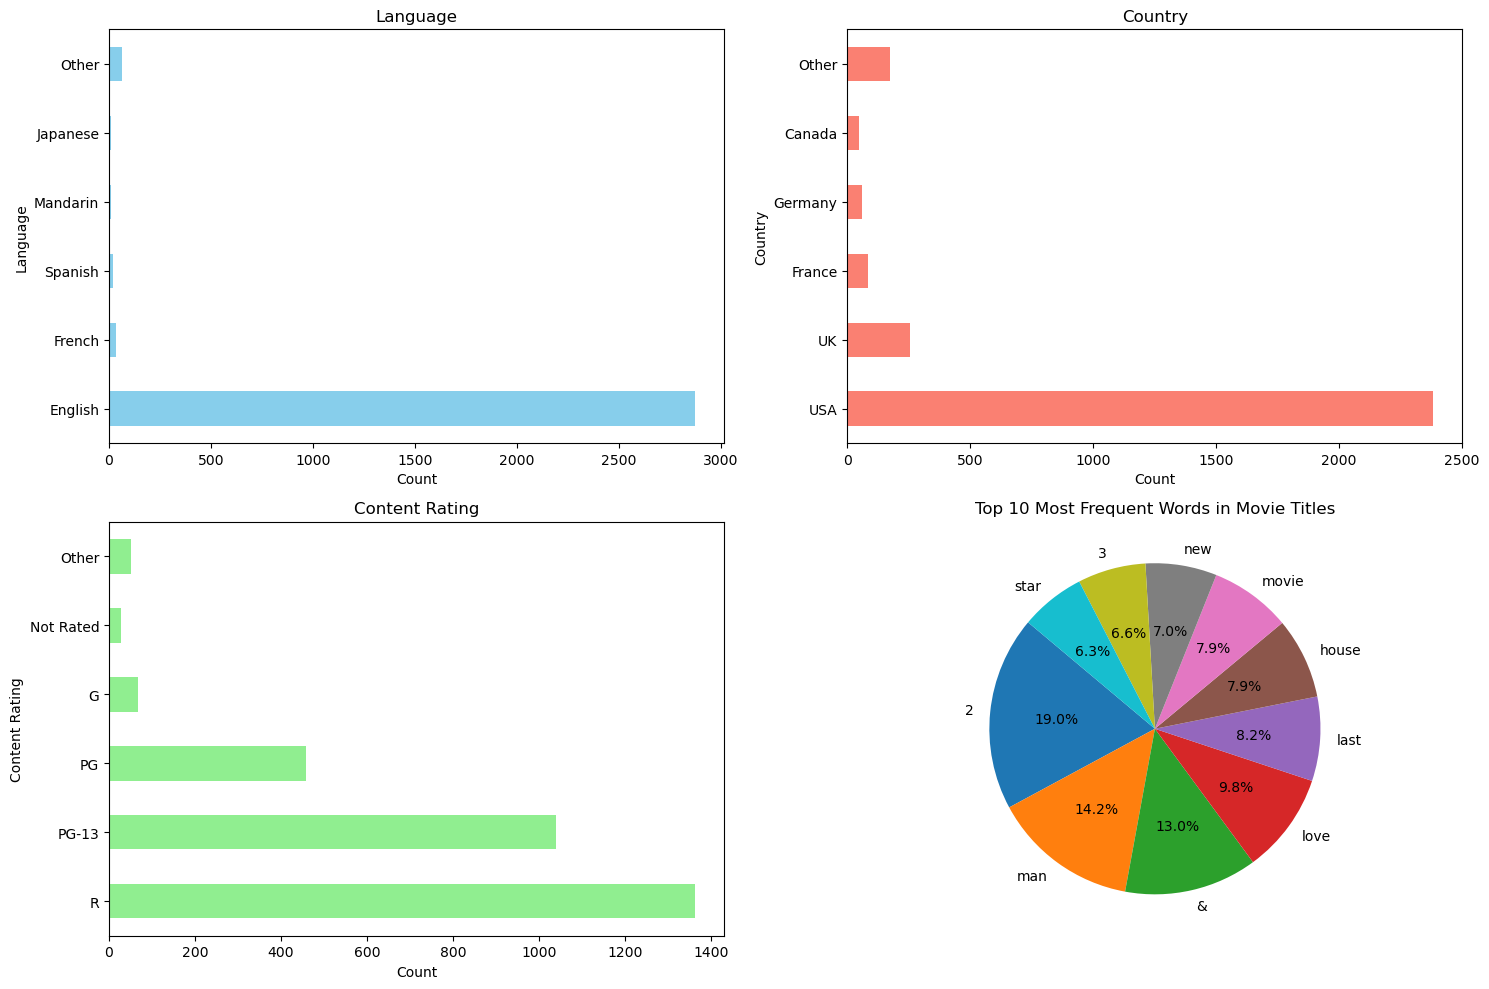

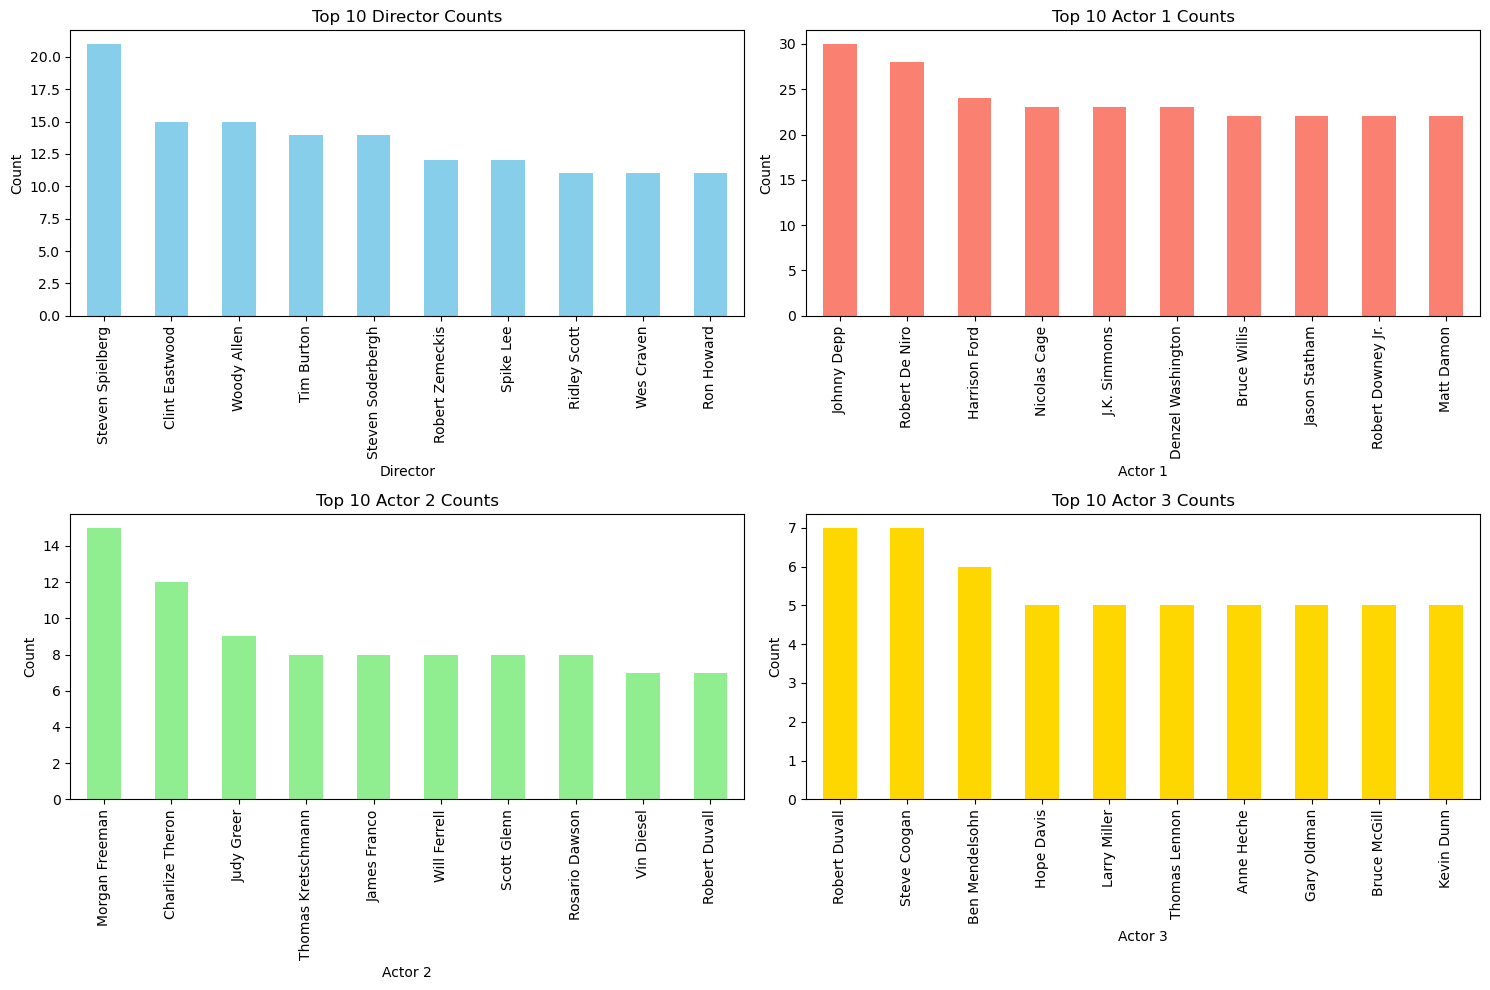

<Axes: >

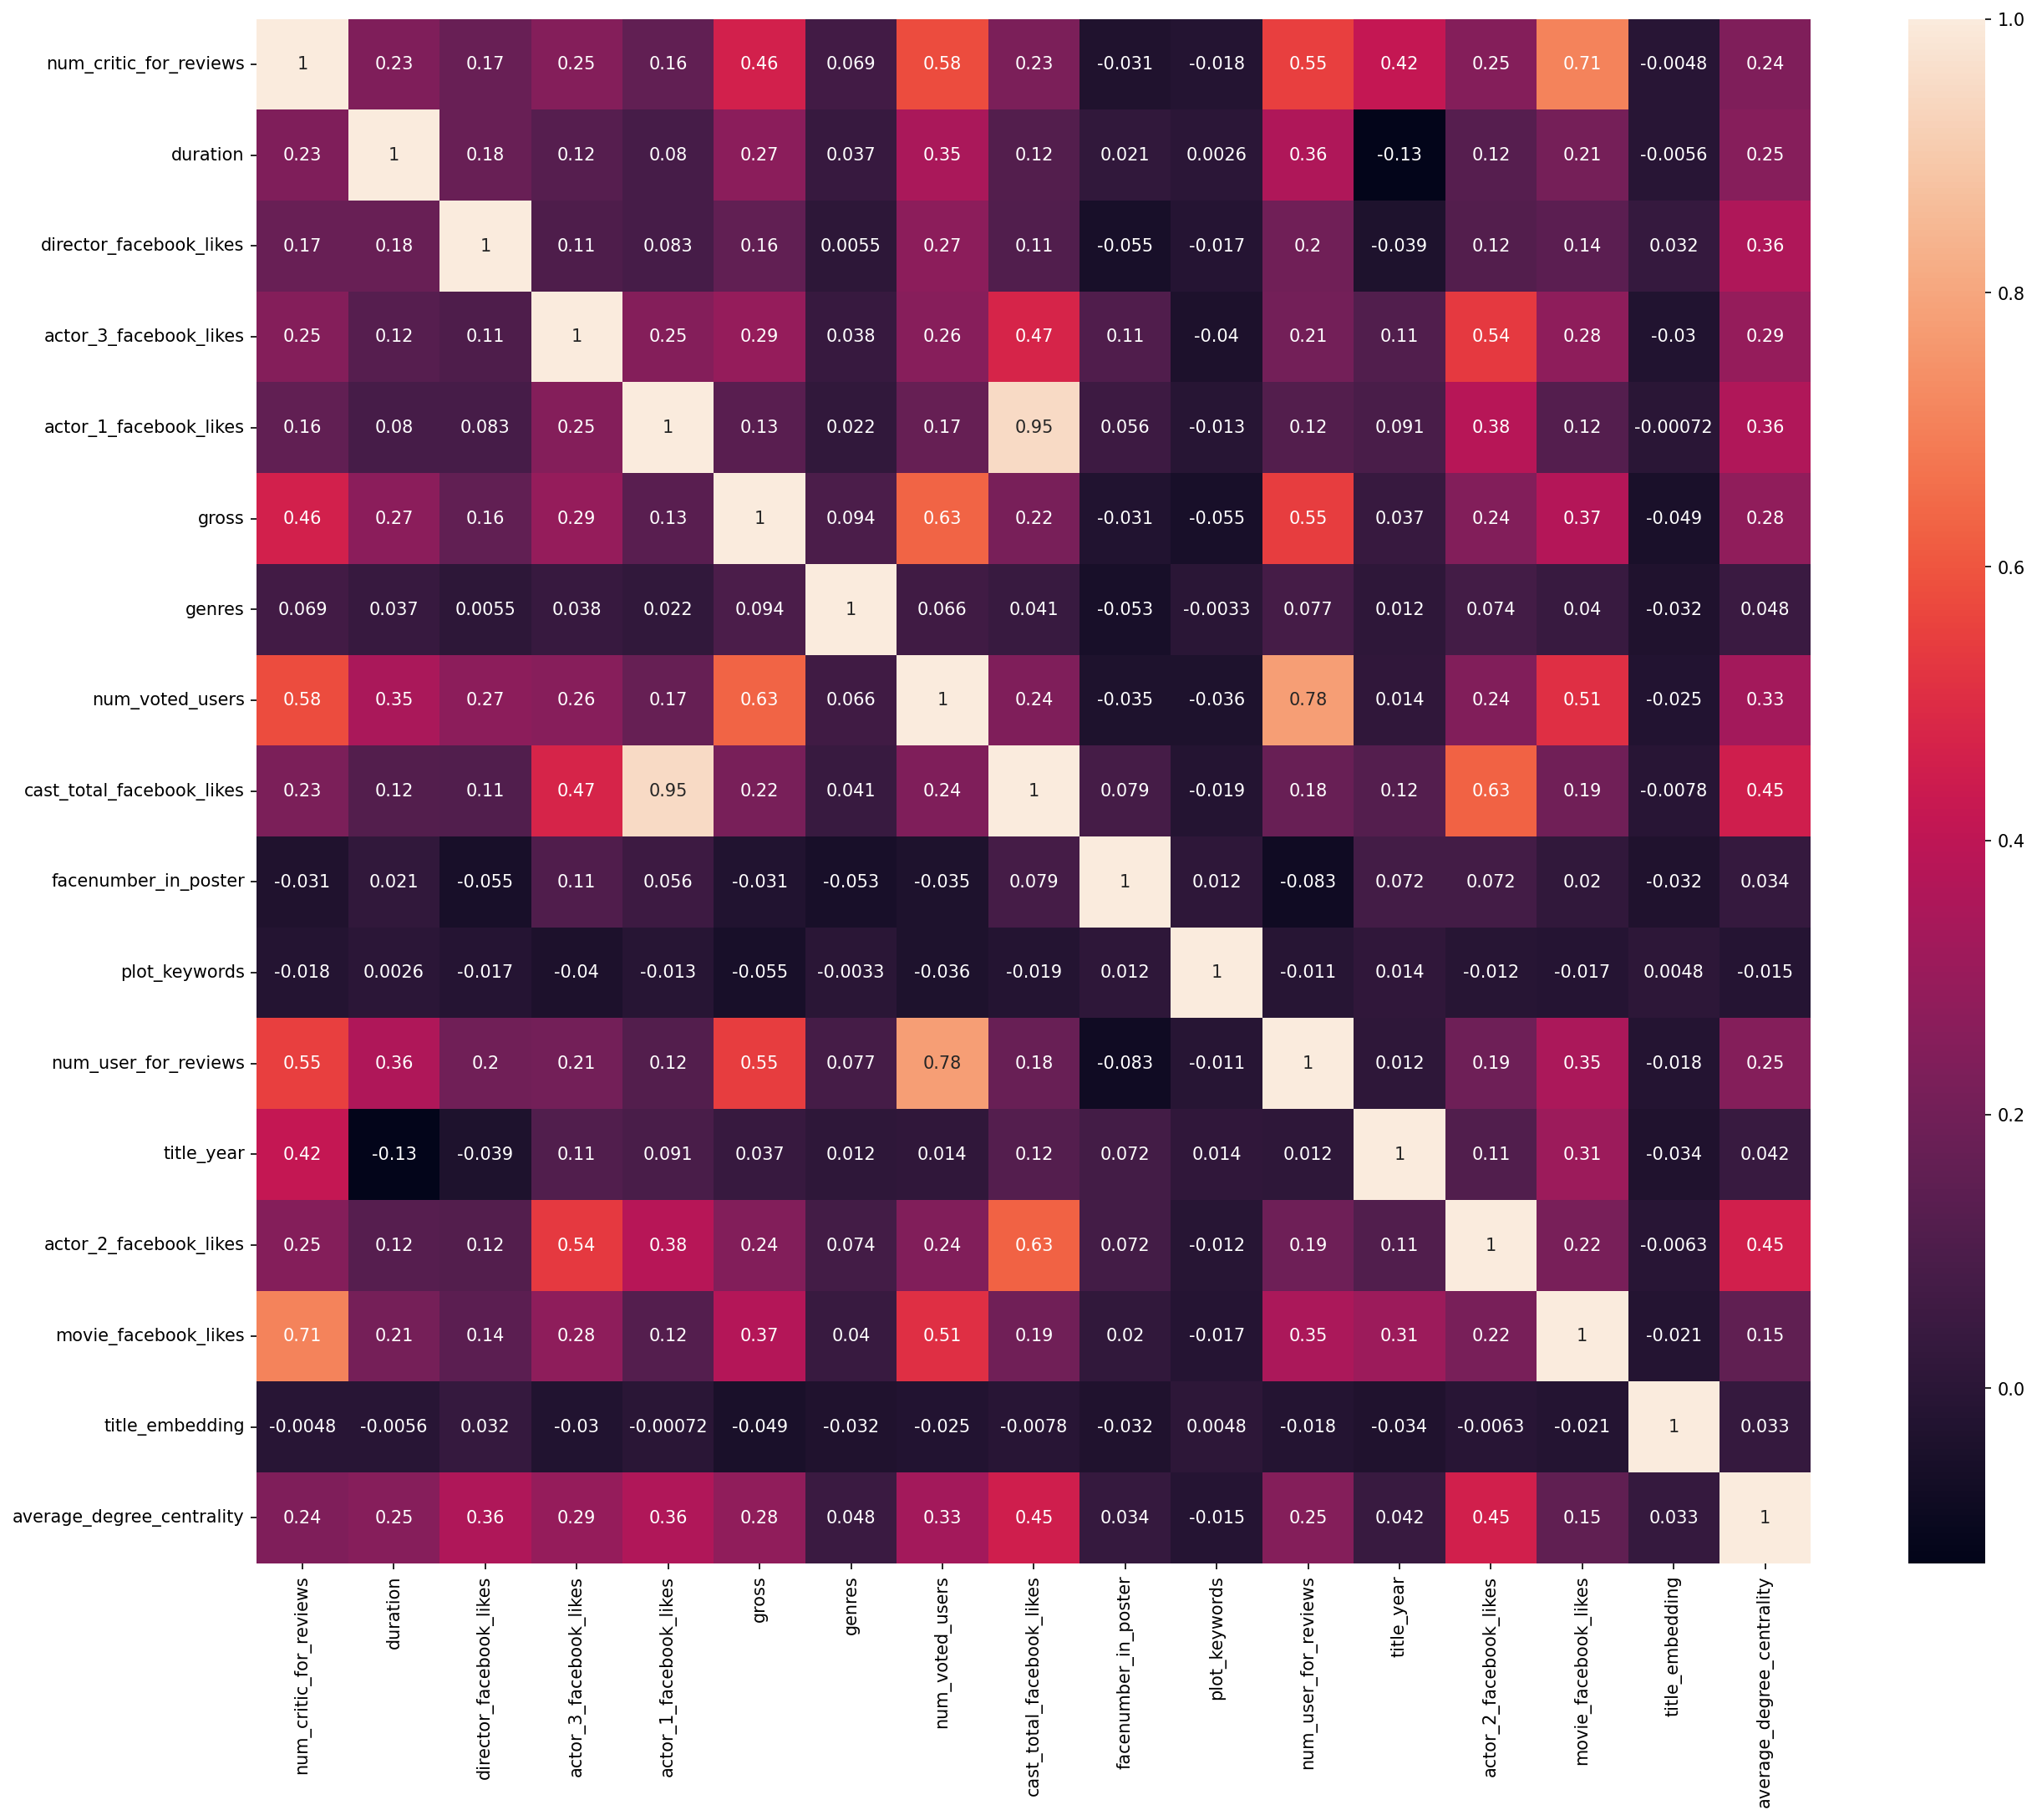

In [419]:

#Plotting the categorical variables on the target
plot_data = True

if plot_data:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot horizontal bar plot for language
    language_counts = X['language'].value_counts()
    top_languages = language_counts[:5]  # Display only the top 5 languages
    other_languages_count = language_counts[5:].sum()
    top_languages['Other'] = other_languages_count
    top_languages.plot(kind='barh', ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Language')
    axes[0, 0].set_ylabel('Language')
    axes[0, 0].set_xlabel('Count')

    # Plot horizontal bar plot for country
    country_counts = X['country'].value_counts()
    top_countries = country_counts[:5]  # Display only the top 5 countries
    other_countries_count = country_counts[5:].sum()
    top_countries['Other'] = other_countries_count
    top_countries.plot(kind='barh', ax=axes[0, 1], color='salmon')
    axes[0, 1].set_title('Country')
    axes[0, 1].set_ylabel('Country')
    axes[0, 1].set_xlabel('Count')

    # Plot horizontal bar plot for content rating
    content_rating_counts = X['content_rating'].value_counts()
    top_content_ratings = content_rating_counts[:5]  # Display only the top 5 content ratings
    other_content_rating_count = content_rating_counts[5:].sum()
    top_content_ratings['Other'] = other_content_rating_count
    top_content_ratings.plot(kind='barh', ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('Content Rating')
    axes[1, 0].set_ylabel('Content Rating')
    axes[1, 0].set_xlabel('Count')

    # Plot for title words
    # Flatten the list of lists into a single list of words
    words = X['movie_title'].apply(lambda x: x.split())
    all_words = [word.lower() for title_words in words for word in title_words]
    filtered_unique_words = [word for word in all_words if word.lower() not in stop_words]

    # Count the occurrences of each word
    word_counts = Counter(filtered_unique_words)
    top_words = word_counts.most_common(10)

    # Plot the pie chart
    ax = axes[1, 1]
    ax.pie([count for word, count in top_words], labels=[word for word, count in top_words], autopct='%1.1f%%', startangle=140)
    ax.set_title('Top 10 Most Frequent Words in Movie Titles')

    plt.tight_layout()
    plt.show()


# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot director counts
X['director_name'].value_counts().head(10).plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Top 10 Director Counts')
axes[0, 0].set_xlabel('Director')
axes[0, 0].set_ylabel('Count')

# Plot actor 1 counts
X['actor_1_name'].value_counts().head(10).plot(kind='bar', ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Top 10 Actor 1 Counts')
axes[0, 1].set_xlabel('Actor 1')
axes[0, 1].set_ylabel('Count')

# Plot actor 2 counts
X['actor_2_name'].value_counts().head(10).plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Top 10 Actor 2 Counts')
axes[1, 0].set_xlabel('Actor 2')
axes[1, 0].set_ylabel('Count')

# Plot actor 3 counts
X['actor_3_name'].value_counts().head(10).plot(kind='bar', ax=axes[1, 1], color='gold')
axes[1, 1].set_title('Top 10 Actor 3 Counts')
axes[1, 1].set_xlabel('Actor 3')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Correlation HeatMap
plt.figure(figsize=(20,16), dpi=150)
sns.heatmap(X[numeric_features].corr(), annot=True)


# Data Preprocessor

In [444]:
# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Transformers for name features
name_transformers = []
for feature in name_features:
    if feature in X.columns:
        name_transformer = Pipeline(steps=[
            ('vectorizer', TfidfVectorizer()), 
        ])
        name_transformers.append((feature, name_transformer, feature))

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        *name_transformers
    ])

print(OneHotEncoder().fit_transform(X[categorical_features]).toarray().shape)
print(CountVectorizer().fit_transform(X['director_name']).shape)
print(CountVectorizer().fit_transform(X['actor_1_name']).shape)
print(CountVectorizer().fit_transform(X['actor_2_name']).shape)
print(CountVectorizer().fit_transform(X['actor_3_name']).shape)

X_processed = preprocessor.fit_transform(X)
print("Shape of processed data:", X_processed.shape)
print(X_processed.toarray()[0])

(3004, 3006)
(3004, 1884)
(3004, 1864)
(3004, 2598)
(3004, 2911)


Shape of processed data: (3004, 12279)
[ 0.16819334 -1.69245592 -0.25111333 ...  0.          0.
  0.        ]


# Train-Test Split

In [421]:
# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)



(2703, 25) (2703,)
(301, 25) (301,)


## Distribution of Movie Ratings


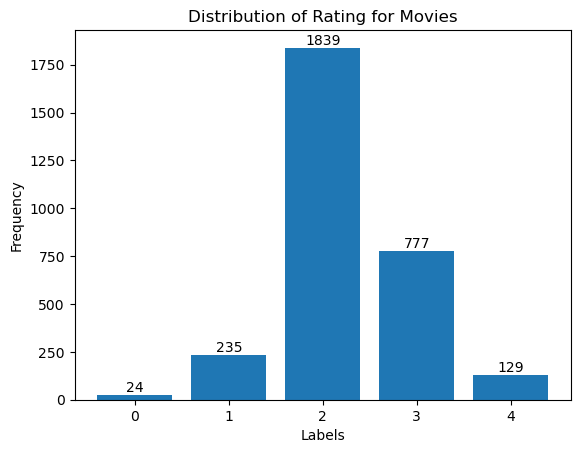

In [422]:
# Plot bar plot of y
counts = np.bincount(y)
plt.bar(range(len(counts)), counts)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Rating for Movies')

# Annotate each bar with its count
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

## Min, Max, Average, Variance

In [391]:
print("Minimum of Ratings:", round(min(y),2))
print("Maximum of Ratings:", round(max(y),2))
print("Average of Ratings:", round(np.mean(y),2))
print("Variance of Ratings:",round(np.var(y),2))

Minimum of Ratings: 0
Maximum of Ratings: 4
Average of Ratings: 2.25
Variance of Ratings: 0.48


## Dataframe



In [392]:
# Combine X_train and y_train into one dataframe for visualization
train_data = X_train.copy()
train_data['imdb_score'] = y_train

import numpy as np
import matplotlib.pyplot as plt

def generate_list(df, feature_name, min_occur=3):
    # Preprocess feature names to ensure they are in suitable format
    df[feature_name] = df[feature_name].str.split('|')
    
    # Step 1: Track all ratings associated with each feature in a dictionary
    feature_dict = {}
    for index, row in df.iterrows():
        feats = row[feature_name]
        for feat in feats:
            if feat not in feature_dict:
                feature_dict[feat] = ([df['imdb_score'][index]], 1)  # Use 'imdb_score' for movie ratings
            else:
                feature_dict[feat] = (feature_dict[feat][0] + [df['imdb_score'][index]], feature_dict[feat][1] + 1)
    
    # Step 2: Calculate average ratings for each feature and filter based on criteria
    filtered_feature_dict = {}
    for key in feature_dict:
        avg_score = sum(feature_dict[key][0]) / feature_dict[key][1]  # Average of all imdb_scores
        if feature_dict[key][1] >= min_occur:
            filtered_feature_dict[key] = avg_score

       
    # Step 3: Create and sort a list of tuples (dictionary value, key)
    lst = sorted(filtered_feature_dict.items(), key=lambda x: x[1])
    
    # Step 4: Create a list of only the feature names, from lowest rating to highest rating
    feature_list = [item[0] for item in lst]
    ratings_list = [item[1] for item in lst]
    
    # Get the variance of the ratings. This is helpful for determining the usefulness of the information
    var = round(np.var(ratings_list), 3)
    
    # Visualization
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(feature_list, ratings_list, align='center', color='skyblue')
    ax.invert_yaxis()  # Invert y-axis to show highest rating on top
    ax.set_xlabel('Average IMDb Score')
    ax.set_ylabel(feature_name)
    ax.set_title(f'{feature_name} vs. Average Movie Ratings (Variance: {var})')
    plt.show()
    
    return feature_list

if False:
    generate_list(train_data, "director_name", min_occur = 6)
    generate_list(train_data, "actor_1_name", min_occur = 6)
    generate_list(train_data, "actor_2_name", min_occur = 6)
    generate_list(train_data, "actor_3_name", min_occur = 3)
    generate_list(train_data, "content_rating", min_occur = 3)

## Pair Plot

In [ ]:
# Create a pairplot
pairplot = sns.pairplot(train_data, hue='imdb_score_binned', diag_kind='kde')

# save image
pairplot.savefig('pairplot.png')

## K-NN 

In [423]:
# Feature selection 
feature_selection = SelectKBest(score_func=f_classif, k=10)

# Define the pipeline with preprocessing, feature selection, and KNN classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('knn', KNeighborsClassifier(weights='distance'))
])

# Define parameter grid
param_grid = {
    'knn__n_neighbors': [5, 15, 25, 35, 55],  
    'knn__metric': ['euclidean', 'manhattan', 'cosine'],
}

# Perform grid search with cross-validation
knn_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=0)
knn_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'actor_1_facebook_likes',
                                                                          'gross',
                                                                          'genres',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',
                                                                          '...
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_1_name'),
                                                                        ('actor_3_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_3_name')])),
                                       ('feature_selection', SelectKBest()),
                                       ('knn',
                                        KNeighborsClassifier(weights='distance'))]),
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'cosine'],
                         'knn__n_neighbors': [5, 15, 25, 35, 55]},
             scoring='accuracy')

In [424]:
# Get the best parameters and best score
best_params = knn_grid_search.best_params_
best_score = knn_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

# Evaluate on the validation set using the best model
knn_best_model = knn_grid_search.best_estimator_

# View accuracy
val_accuracy = accuracy_score(y_val, knn_best_model.predict(X_val))
print("Validation Accuracy with Best Model:", val_accuracy)

Best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 35}
Best Accuracy: 0.6774019305812282
Validation Accuracy with Best Model: 0.717607973421927


### Predict with KNN

In [425]:
# Make predictions on X_test with KNN
predictions = knn_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('knn_predictions.csv', index=False)

## Decision Tree / Random Forest


In [270]:
# Define preprocessing steps
imputer = SimpleImputer(strategy='mean') 
feature_selector = SelectKBest(score_func=f_classif, k=10)  
classifier = RandomForestClassifier(random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', imputer),
    ('feature_selector', feature_selector),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200], 
    'classifier__min_samples_split': [5, 10],
    'classifier__min_samples_leaf': [1, 2],
}

# Perform grid search with cross-validation
rf_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=0)
rf_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'actor_1_facebook_likes',
                                                                          'gross',
                                                                          'genres',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',
                                                                          '...
                                                                        ('actor_3_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_3_name')])),
                                       ('imputer', SimpleImputer()),
                                       ('feature_selector', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [5, 10],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy')

In [395]:
# Get the best parameters and best score
best_params = rf_grid_search.best_params_
best_score = rf_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

# Evaluate on the validation set using the best model
rf_best_model = rf_grid_search.best_estimator_
val_accuracy = rf_best_model.score(X_val, y_val)
print("Validation Accuracy with Best Model:", val_accuracy)

Best Parameters: {'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best Accuracy: 0.6851714931197371
Validation Accuracy with Best Model: 0.717607973421927


## Predict with Random Forest

In [188]:
# Make predictions on X_test with Random Forest
predictions = rf_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('rf_predictions.csv', index=False)

## SVM


In [383]:
# Define feature selection, imputation, and SVM classifier
imputer = SimpleImputer(strategy='mean') 
feature_selector = SelectKBest(score_func=f_classif, k="all")  
classifier = SVC(gamma='scale')

# Define the pipeline including feature engineering
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', imputer),
    ('feature_selector', feature_selector),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'classifier__C': [1, 3, 5, 10]
}

# Perform grid search with cross-validation
svm_grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=0)   # Verbose shows comments during search
svm_grid_search.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'actor_1_facebook_likes',
                                                                          'gross',
                                                                          'genres',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',...
                                                                                          TfidfVectorizer())]),
                                                                         'actor_2_name'),
                                                                        ('actor_1_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_1_name'),
                                                                        ('actor_3_name',
                                                                         Pipeline(steps=[('vectorizer',
                                                                                          TfidfVectorizer())]),
                                                                         'actor_3_name')])),
                                       ('imputer', SimpleImputer()),
                                       ('feature_selector',
                                        SelectKBest(k='all')),
                                       ('classifier', SVC())]),
             param_grid={'classifier__C': [1, 3, 5, 10]}, scoring='accuracy')

In [396]:
# Get the best parameters and best score
best_params = svm_grid_search.best_params_
best_score = svm_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

# Evaluate on the validation set using the best model
svm_best_model = svm_grid_search.best_estimator_
val_accuracy = svm_best_model.score(X_val, y_val)
print("Validation Accuracy with Best Model:", val_accuracy)
print("Classification Report:", classification_report(y_val, svm_best_model.predict(X_val), zero_division=1))


Best Parameters: {'classifier__C': 10}
Best Accuracy: 0.7181057810578106
Validation Accuracy with Best Model: 0.7375415282392026
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       0.00      0.00      1.00        20
           2       0.78      0.88      0.83       197
           3       0.63      0.59      0.61        71
           4       0.67      0.60      0.63        10

    accuracy                           0.74       301
   macro avg       0.62      0.41      0.61       301
weighted avg       0.69      0.74      0.77       301



### Predict with SVM

In [434]:
# Make predictions on X_test with SVM
predictions = svm_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('svm_predictions.csv', index=False)

## Permutation Feature Importance

In [192]:
# Fit your SVM model (best_model) on the training data
svm_best_model.fit(X_train, y_train)

# Compute baseline performance on the validation set
baseline_score = svm_best_model.score(X_val, y_val)

# Compute permutation feature importance
perm_importance = permutation_importance(svm_best_model, X_val, y_val, n_repeats=10, random_state=42)

# Get feature importances and their names
feature_importances = perm_importance.importances_mean
feature_names = X_val.columns


['num_voted_users', 'num_user_for_reviews', 'title_year', 'movie_facebook_likes', 'gross', 'num_critic_for_reviews', 'actor_3_facebook_likes', 'duration', 'facenumber_in_poster', 'language']


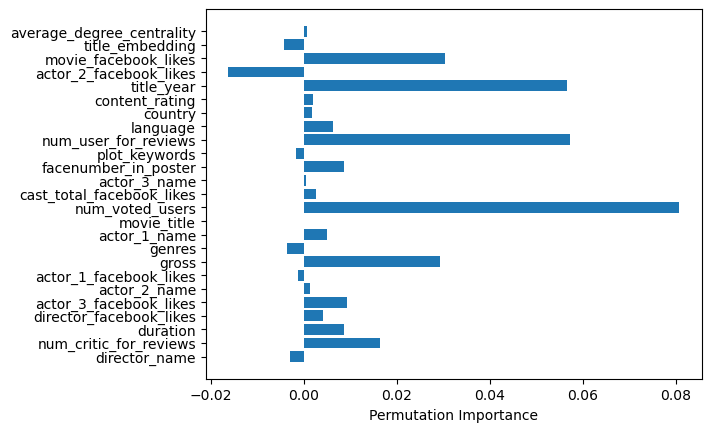

In [193]:

features = zip(feature_names, feature_importances)
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

# Get the top 10 features
top_10_features = sorted_features[:10]
top_10_feature_names = [feat_name for feat_name, feat_imp in top_10_features]
print(top_10_feature_names)

# Plot feature importance
plt.barh(feature_names, feature_importances)
plt.xlabel('Permutation Importance')
plt.show()


## Linear Regression


In [430]:
# Simple Linear regression with numeric variables only
X_lin_reg = X_train[numeric_features].values

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_lin_reg, y_train)

y_pred = lin_reg_model.predict(X_val[numeric_features].values)

# Round the continuous predictions to the nearest integer
y_pred_discrete = np.round(y_pred).astype(int)
y_pred_discrete = np.clip(y_pred_discrete, 0, 4)

mse = mean_squared_error(y_val, y_pred)
chi_square_error = mse / y_val.var()

r2 = r2_score(y_val, y_pred)

print(list(zip(y_pred_discrete, y_val.values)))

print()
print("Mean Squared Error:", mse)
print("Chi-Square Error:", chi_square_error)
print("R^2:", r2)
print()

lin_reg_accuracy = accuracy_score(y_val, y_pred_discrete)
print("Validation Accuracy with Best Model:", lin_reg_accuracy)



[(2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 1), (2, 1), (2, 1), (2, 2), (2, 2), (2, 3), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 3), (3, 3), (2, 2), (3, 3), (2, 2), (2, 2), (2, 2), (3, 3), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 1), (2, 2), (2, 1), (2, 2), (2, 2), (2, 2), (2, 3), (3, 3), (2, 1), (2, 2), (3, 3), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (3, 3), (3, 2), (3, 3), (3, 3), (2, 2), (2, 3), (3, 3), (2, 2), (2, 2), (2, 2), (2, 2), (3, 3), (4, 4), (3, 2), (2, 2), (2, 1), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (3, 3), (2, 2), (2, 2), (2, 2), (2, 3), (2, 2), (2, 3), (2, 2), (2, 1), (2, 2), (2, 2), (2, 2), (2, 2), (3, 2), (3, 3), (2, 1), (2, 2), (2, 3), (2, 2), (3, 3), (2, 2), (2, 2), (2, 3), (3, 3), (3, 3), (3, 3), (2, 3), (2, 2), (2, 3), (2, 2), (2, 3), (2, 2), (2, 1), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 3), (2, 2), (2, 1), (3, 4), (2, 3), (3, 2), (3, 3), (2, 1),

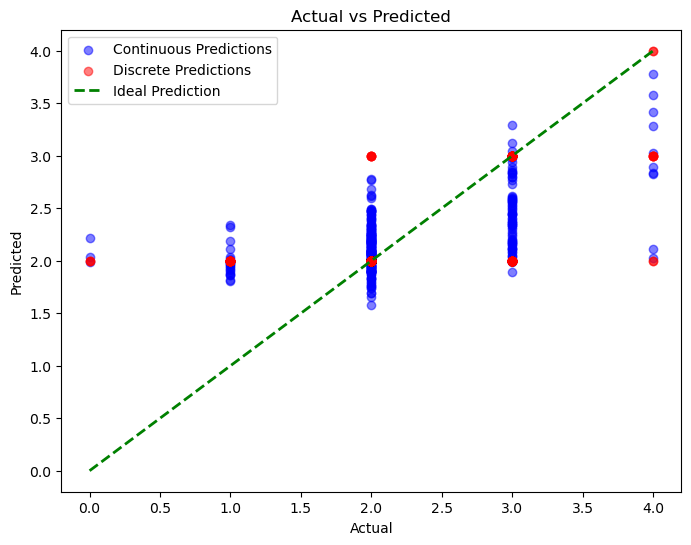

In [431]:

# Plot the actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, color='blue', alpha=0.5, label='Continuous Predictions')
plt.scatter(y_val, y_pred_discrete, color='red', alpha=0.5, label='Discrete Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--', color='green', linewidth=2, label='Ideal Prediction')  # Plot the diagonal line
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()


# Further implement
## Ensemble Method
Stacking or Voting Classifier / Feature engineering / Data processing / Hyperparameter Tuning / Different cross-val

In [445]:
# Define the ensemble model                  
voting_clf = Pipeline([
    ('voting', VotingClassifier(estimators=[
        ('knn', knn_best_model),
        # ('linear_reg', lin_reg_model),        can't use linear regression as it is a regressor not a classifier
        ('rf', rf_best_model),
        ('svm', svm_best_model)
    ], voting='hard'))                   
])

voting_clf.fit(X_train, y_train)

voting_pred = voting_clf.predict(X_val)

# Evaluate the voting classifier
voting_accuracy = accuracy_score(y_val, voting_pred)
print("Voting Classifier Accuracy:", voting_accuracy)
print("Classification Report:", classification_report(y_val, voting_clf.predict(X_val), zero_division=1))

Voting Classifier Accuracy: 0.7441860465116279
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       1.00      0.10      0.18        20
           2       0.75      0.94      0.83       197
           3       0.70      0.45      0.55        71
           4       1.00      0.50      0.67        10

    accuracy                           0.74       301
   macro avg       0.89      0.40      0.45       301
weighted avg       0.76      0.74      0.71       301



In [446]:
ensemble_predictions = voting_clf.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': ensemble_predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('ensemble_predictions.csv', index=False)

### Compare csv's for different predictions


In [447]:
csv1 = 'svm_predictions.csv'
csv2 = 'ensemble_predictions.csv'

df1_name = csv1.split('_')[0]
df2_name = csv2.split('_')[0]

# Read the first CSV file
df1 = pd.read_csv(csv1)

# Read the second CSV file
df2 = pd.read_csv(csv2)

# Compare the two DataFrames
differences = df1.compare(df2)
differences = differences.rename(columns={'self': df1_name, 'other': df2_name})

# Print the differences
print("Differences between", csv1, "and", csv2, "with movie titles:")
print("Number of differences:", len(differences))

movie_titles = X_test.loc[differences.index, 'movie_title']
differences['movie'] = movie_titles

# Join movie titles to differences DataFrame
display(differences)



Differences between svm_predictions.csv and ensemble_predictions.csv with movie titles:
Number of differences: 91


imdb_score_binned                                     movie
                  svm ensemble                                 
3                 3.0      2.0                   road perdition
5                 3.0      2.0                        blindness
16                1.0      2.0                   deep end ocean
20                3.0      2.0                       die hard 2
30                4.0      3.0                           frozen
..                ...      ...                              ...
717               2.0      3.0                  horse whisperer
720               1.0      2.0                         covenant
730               3.0      2.0                             1911
734               2.0      3.0                    boogie nights
748               3.0      2.0  abraham lincoln: vampire hunter

[91 rows x 3 columns]

## View top models from grid search

In [ ]:
def viewTopModels(results, num):
    # Sort the results by mean_test_score in descending order to find the top-performing models
    top_models = results.sort_values(by='mean_test_score', ascending=False).head(num)

    # Print the top models along with their parameters and scores
    print(f"Top {num} Models:")
    top_models[['params', 'mean_test_score']].to_csv("top_models.csv", index=False)
